<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Timeseries Properties, Autoregressive and Moving Average Models


---

## Learning Objectives


### Core

- Understand the different components of an ARIMA model
- Fit an ARIMA model with statsmodels
- Forecast with the fitted model
- Evaluate the model

### Target

- Know about some common patterns in (partial) autocorrelations and their relations to ARIMA models
- Investigate the residuals
- Know about model limitations

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-1">Learning Objectives</a></span><ul class="toc-item"><li><span><a href="#Core" data-toc-modified-id="Core-1.1">Core</a></span></li><li><span><a href="#Target" data-toc-modified-id="Target-1.2">Target</a></span></li></ul></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2">Introduction</a></span></li><li><span><a href="#Load-the-unemployment-data" data-toc-modified-id="Load-the-unemployment-data-3">Load the unemployment data</a></span></li><li><span><a href="#Create-a-datetime-index" data-toc-modified-id="Create-a-datetime-index-4">Create a datetime index</a></span></li><li><span><a href="#Visually-examine-the-unemployment-rate" data-toc-modified-id="Visually-examine-the-unemployment-rate-5">Visually examine the unemployment rate</a></span></li><li><span><a href="#Time-series-models" data-toc-modified-id="Time-series-models-6">Time series models</a></span></li><li><span><a href="#ARMA-and-ARIMA-models" data-toc-modified-id="ARMA-and-ARIMA-models-7">ARMA and ARIMA models</a></span></li><li><span><a href="#Fitting-ARIMA-models" data-toc-modified-id="Fitting-ARIMA-models-8">Fitting ARIMA models</a></span></li><li><span><a href="#How-to-choose-the-right-p-and-q-parameters" data-toc-modified-id="How-to-choose-the-right-p-and-q-parameters-9">How to choose the right <code>p</code> and <code>q</code> parameters</a></span><ul class="toc-item"><li><span><a href="#Model-tuning" data-toc-modified-id="Model-tuning-9.1">Model tuning</a></span></li><li><span><a href="#Automatic-selection-of-ARMA-model-based-on-AIC-or-BIC" data-toc-modified-id="Automatic-selection-of-ARMA-model-based-on-AIC-or-BIC-9.2">Automatic selection of ARMA model based on AIC or BIC</a></span></li><li><span><a href="#Let's-fit-our-best-model-according-to-BIC,-ARMA(2,3)" data-toc-modified-id="Let's-fit-our-best-model-according-to-BIC,-ARMA(2,3)-9.3">Let's fit our best model according to BIC, ARMA(2,3)</a></span></li><li><span><a href="#Forecast-for-this-model" data-toc-modified-id="Forecast-for-this-model-9.4">Forecast for this model</a></span></li><li><span><a href="#Scores" data-toc-modified-id="Scores-9.5">Scores</a></span></li><li><span><a href="#Residuals" data-toc-modified-id="Residuals-9.6">Residuals</a></span></li></ul></li><li><span><a href="#Summary-of-time-series-modeling" data-toc-modified-id="Summary-of-time-series-modeling-10">Summary of time series modeling</a></span></li><li><span><a href="#Model-Limitations" data-toc-modified-id="Model-Limitations-11">Model Limitations</a></span></li><li><span><a href="#Additional-Resources" data-toc-modified-id="Additional-Resources-12">Additional Resources</a></span></li></ul></div>

## Introduction

In this lesson we will meet one of the main classes of time series models, **ARIMA (Autoregressive Integrated Moving Average Models)**. We will use statsmodels to fit ARIMA models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
np.set_printoptions(precision=4)
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
def autocorr_plots(y, lags=None):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    return fig, ax

## Load the unemployment data


This is historical monthly unemployment data in the US that we have previously cleaned and explored. 

In [5]:
data = pd.read_csv(
    '../datasets/unemployment_cleaned.csv')

In [6]:
data.head(10)

,date,unemployment_rate
0,1999-01,4.3
1,1999-02,4.4
2,1999-03,4.2
3,1999-04,4.3
4,1999-05,4.2
5,1999-06,4.3
6,1999-07,4.3
7,1999-08,4.2
8,1999-09,4.2
9,1999-10,4.1


In [7]:
data.dtypes

date                  object
unemployment_rate    float64
dtype: object

## Create a datetime index


We have to make sure the index is the `datetime` object:

In [8]:
data['date'] = pd.to_datetime(data['date']).dt.to_period('M')
data.set_index('date', inplace=True, drop=True)
data.head()

,unemployment_rate
date,
1999-01,4.3
1999-02,4.4
1999-03,4.2
1999-04,4.3
1999-05,4.2


## Visually examine the unemployment rate

Make a plot of the unemployment rate.

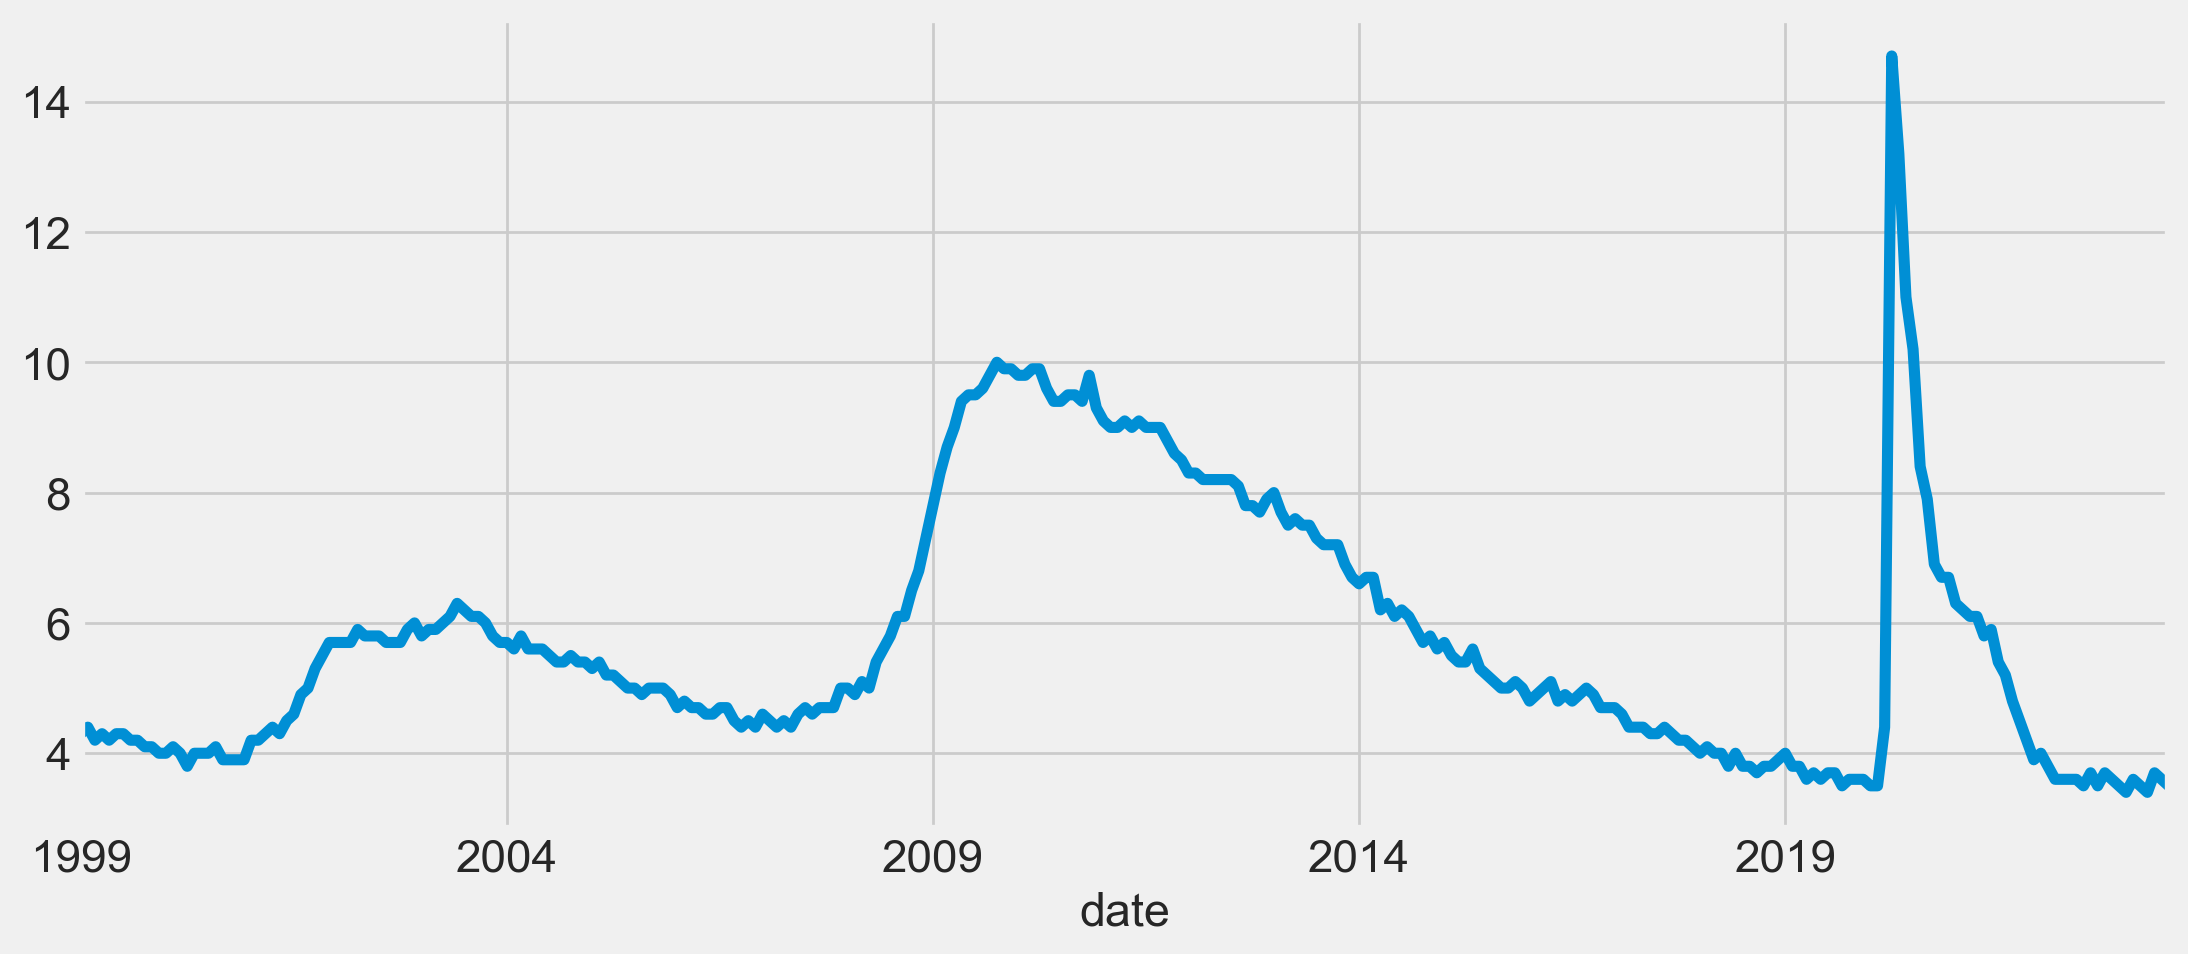

In [9]:
data['unemployment_rate'].plot(lw=4, figsize=(12, 5))
plt.show()

In [10]:
# let's keep unemployment_rate as a variable for later
urate = data.unemployment_rate


## Time series models


What we would like to do in time series modeling is to predict future values in the time series from the preceding ones, e.g.

- the price of an asset tomorrow given the price today
- tomorrow's weather given today's weather and last week's and last year's at the same date

We will have to formulate something like

$$
y_t = f(y_{t-1},y_{t-2},\ldots,y_{1},y_{0}) + \epsilon_t
$$

The task is to find the appropriate function defining our model. As usual, we will have some irreducible error limiting the quality of our predictions.

## ARMA and ARIMA models

**ARMA** models are essentially regression models. To predict the value $y_t$ of the time series at time $t$, we use: 
- the preceding observations $y_{t-1}, y_{t-2}, \ldots, y_{t-p}$ up to $p$ previous time steps. This is called the **Autoregressive (AR)** component of the model. 
- the preceding noise terms $\epsilon_{t-1}, \epsilon_{t-2}, \ldots, \epsilon_{t-q}$ up to q previous time steps. This is called the **Moving Average (MA)** component of the model. 

In this way we base our predictions on previous observations, and we also prescribe a way to predict how being wrong about the last predictions should influence our future predictions.

In total, our model will have $p+q$ parameters and can be formulated like this:

$$
\begin{eqnarray*}
y_t &=& \phi_0 + \phi_1  y_{t-1}\ +\ ...\ +\ \phi_p  y_{t-p}\ + \theta_{1} \epsilon_{t-1} + ... +\theta_{q} \epsilon_{t-n} +\ \epsilon_t \\
y_t &=& \phi_0+\sum_{j=1}^p \phi_j y_{t-j} + \sum_{i=1}^q \theta_i \epsilon_{t-i} + \epsilon_t
\end{eqnarray*}
$$

where 

$$\phi_0=\left(1-\sum_{j=1}^p \phi_j\right)\mu$$

Here $\mu$ is the mean of the time series, and $\epsilon_t$ are uncorrelated noise terms stemming from the same normal distribution with mean zero and the same standard deviation.

For the ARMA model to work properly, the time series is required to be stationary. If initially it is not stationary, it may be made stationary (to sufficient degree) by suitable transformations and differencing.

The Auto Regressive Integrated Moving Average Model (**ARIMA**)
is basically the same as an 
`ARMA(p, q)` model, but we additionally indicate how many differencing steps we carried out, i.e. we just plug in our initial unemployment rate time series, and then indicate that we want to have it differenced $d$ times ($d=1$ in our case) before fitting an `ARMA(p,q)` model to it.

We denote this as an `ARIMA(p,d,q)` model.

Whereas fitting the AR part is straightforward, fitting the MA part is a bit more tricky because the error terms are unobserved. There are a variety of different ways you can estimate the parameters, some of which are covered in this [paper.](https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf)

In the simpler fitting procedures, a model is iteratively fit, errors are computed, then refit, over and over again until the parameters of the errors converge.


## Checking for Stationarity

In [11]:
def autocorr_plots(y, lags=None):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    return fig, ax

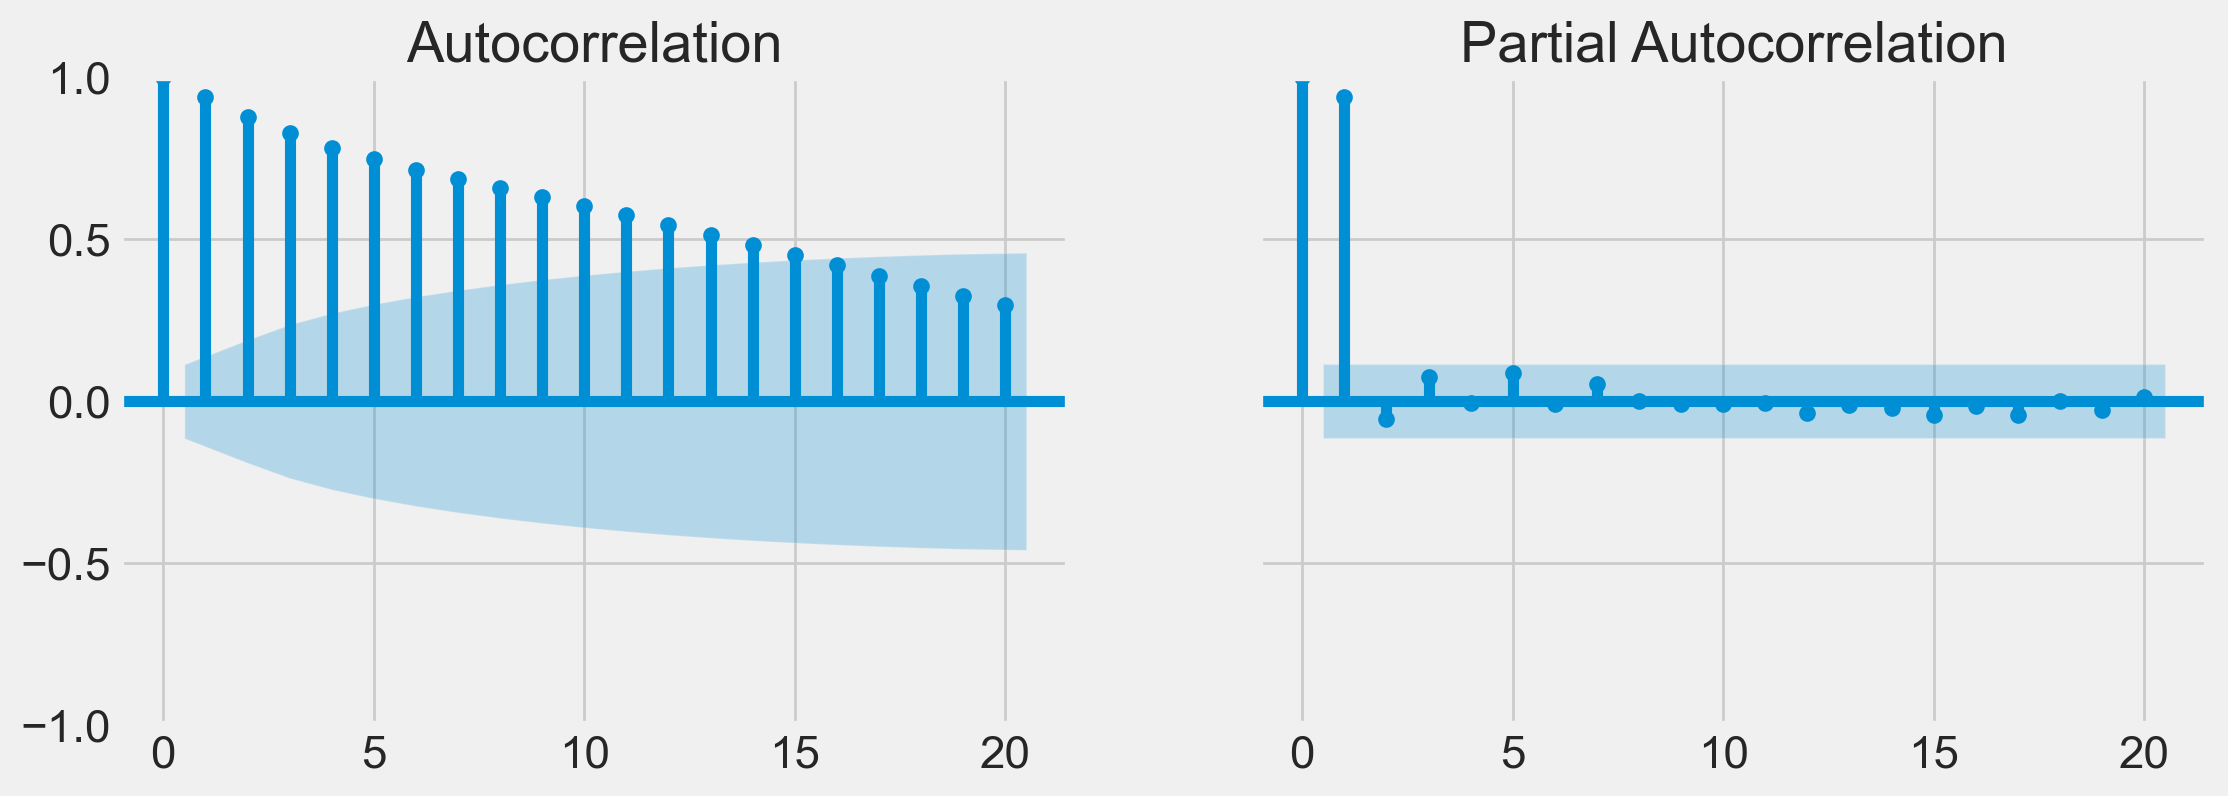

In [12]:
fig, ax = autocorr_plots(urate,lags=20)

The gradually declining ACF indicates that the time series is non stationary, because the autocorrelation changes over time.


## Hypothesis Test for Stationarity

A statistical test for stationarity is the Augmented Dickey-Fuller test:
- H0: There is a unit root in a time series sample (indicating it is non-stationary)
- H1: There is no unit root (so it is stationary)

if the p-value is less than the significance level then we reject the null hypothesis.

In [13]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(urate)
print(f'p-value: {adf_test[1]}')

p-value: 0.05132589197586912


Since our p-value is not less than 0.05, we do not reject the null hypothesis that the time series is not stationary. 

## Fitting ARIMA models


Fitting ARIMA models is very simple. Just pass the argument `order=(p,d,q)` to indicate the order of the ARIMA model. 

See the [statsmodels documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html).

For example, suppose we decided on `p=2`, `d=0`, `q=1`:

Let's create the training and test sets:



In [14]:
# Train based on data up to one year prior
n = len(urate)-12
X_train= urate[:n]
X_test= urate[n:]

In [16]:
from statsmodels.tsa.arima.model import ARIMA

model_test_201=ARIMA(X_train, order=(2,0,1)).fit() # order p, d, q
print(model_test_201.summary())
print(model_test_201.model.order)

D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:      unemployment_rate   No. Observations:                  283
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -282.881
Date:                Fri, 13 Oct 2023   AIC                            575.762
Time:                        18:29:40   BIC                            593.989
Sample:                    01-31-1999   HQIC                           583.070
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6485      1.810      3.120      0.002       2.100       9.197
ar.L1          0.2356      0.213      1.108      0.268      -0.181       0.652
ar.L2          0.6541      0.227      2.883      0.0

This gives us the coefficients for the constant term ($\phi_0$) + ($\epsilon_t$) ,  2 AR coefficients ($\phi_1$) and ($\phi_2$), and 1 MA coefficient ($\theta_1$) for the ARIMA equation:

$$
\begin{eqnarray*}
y_t &=& \phi_0 + \phi_1  y_{t-1}\ +\ ...\ +\ \phi_p  y_{t-p}\ + \theta_{1} \epsilon_{t-1} + ... +\theta_{q} \epsilon_{t-n} +\ \epsilon_t \\
y_t &=& \phi_0+\sum_{j=1}^p \phi_j y_{t-j} + \sum_{i=1}^q \theta_i \epsilon_{t-i} + \epsilon_t
\end{eqnarray*}
$$

And this is the equation that will be used to forecast the `y` values:

<Axes: xlabel='date'>

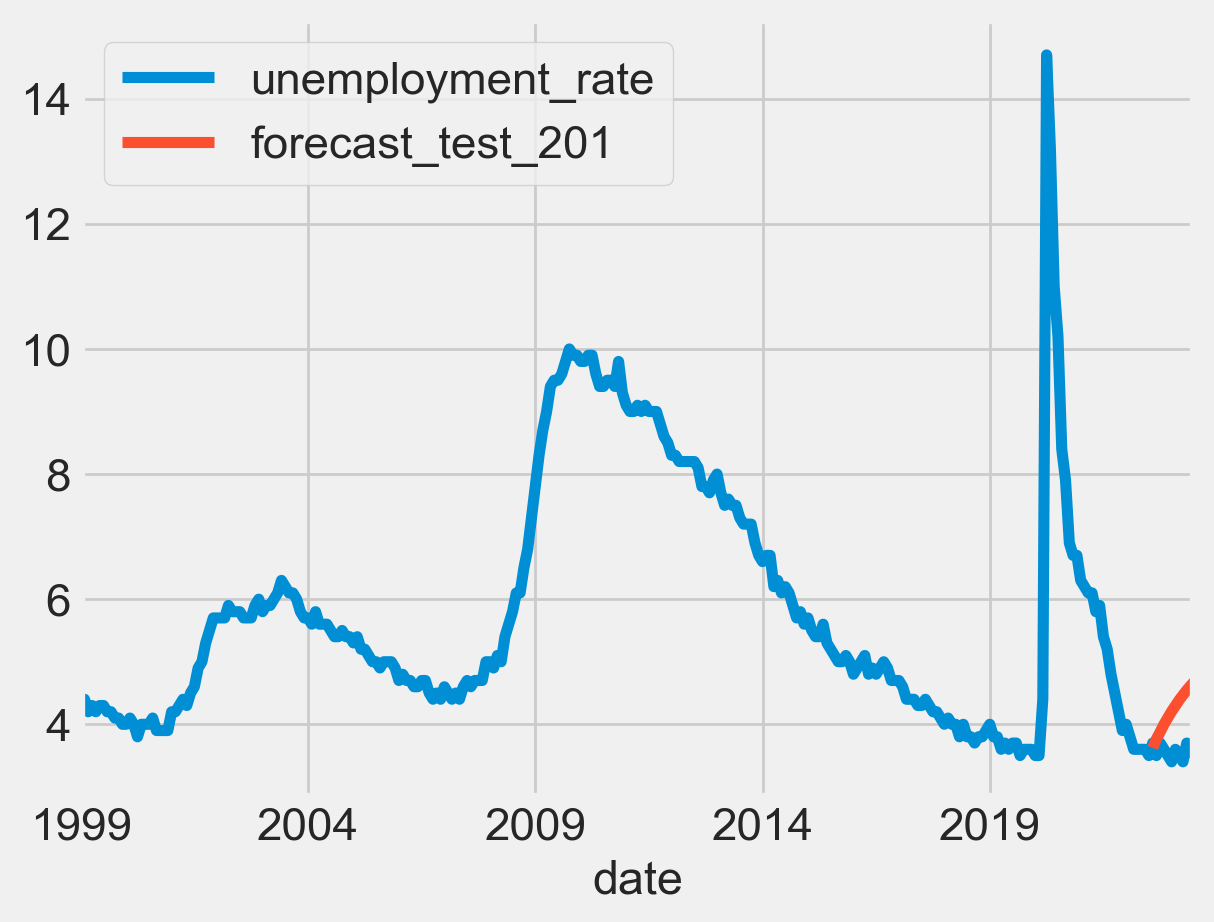

In [17]:
# Forecast 12 months
forecast_test_201 = model_test_201.forecast(len(X_test))

# Store the forecast values back in the dataframe, keeping those before the y_test as NaN
data['forecast_test_201'] = [None]*len(X_train) + list(forecast_test_201)

data.plot()

In [18]:
data.tail(20)


,unemployment_rate,forecast_test_201
date,,
2021-12,3.9,NaN
2022-01,4.0,NaN
2022-02,3.8,NaN
2022-03,3.6,NaN
2022-04,3.6,NaN
2022-05,3.6,NaN
2022-06,3.6,NaN
2022-07,3.5,NaN
2022-08,3.7,3.622490


<Axes: xlabel='date'>

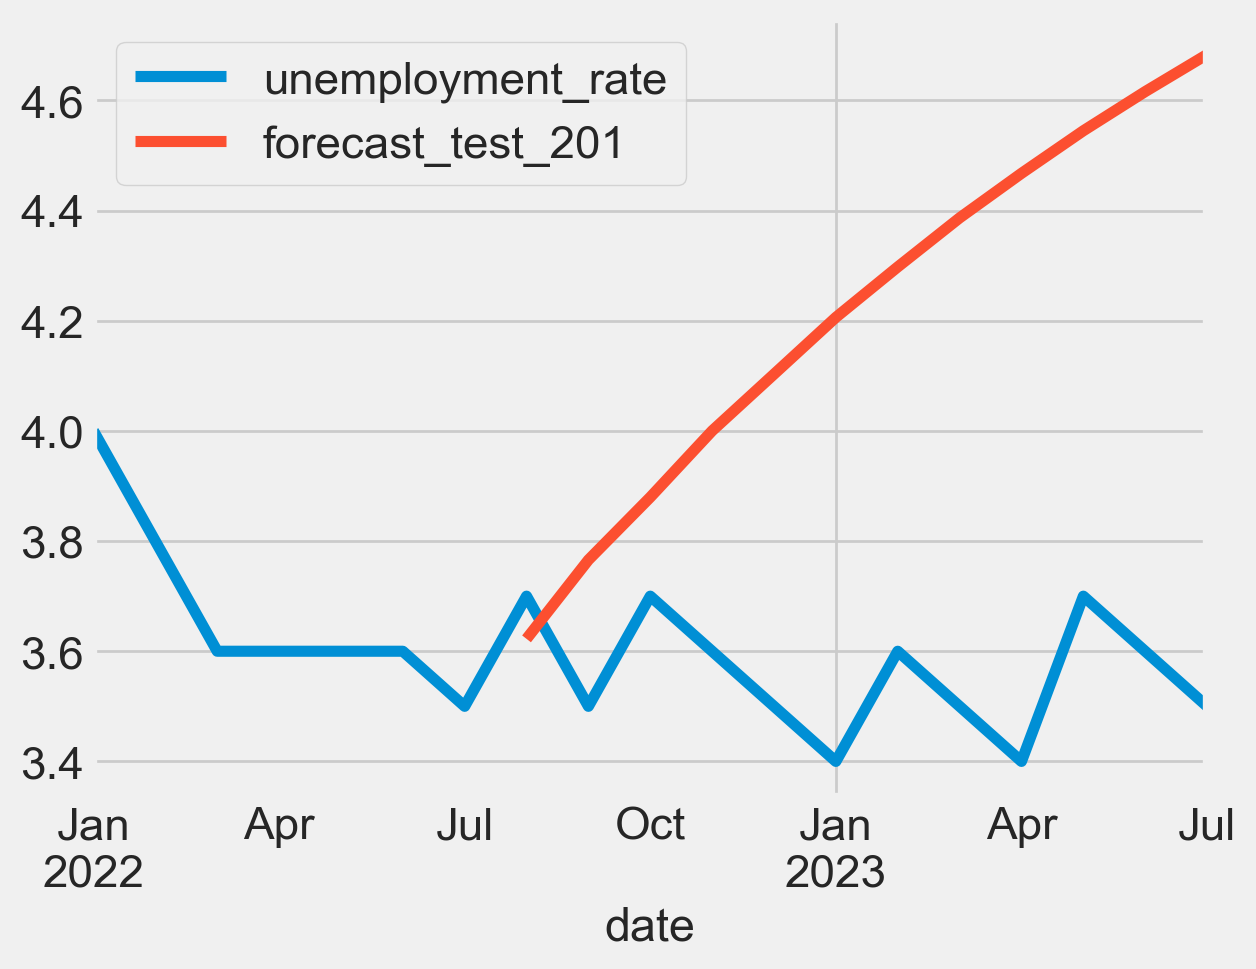

In [19]:
data.loc['2022-01':].plot()

### Model tuning


Now let's try to identify suitable values for the ARIMA model:
- AR(p) 
- MA(q)
- differencing (d)

- p indicates how many prior time periods are taken into consideration for explained autocorrelation. Increasing p would increase the dependency on previous values further (longer lag).
- q indicates how many prior time periods we are considering for observing sudden trend changes.
- d indicates what difference we are anticipating to predict. We pick d in such a way that we produce a stationary time series (if we can).

## Choosing `d` parameter

The `d` parameter specifies the amount of differencing required to make the series stationary. We can inspect the differenced values for stationarity using the ACF, PACF plots.


In [20]:
# Get the differenced series, dropping the first row which will be NaN
udiff = urate.diff()[1:]

<Axes: xlabel='date'>

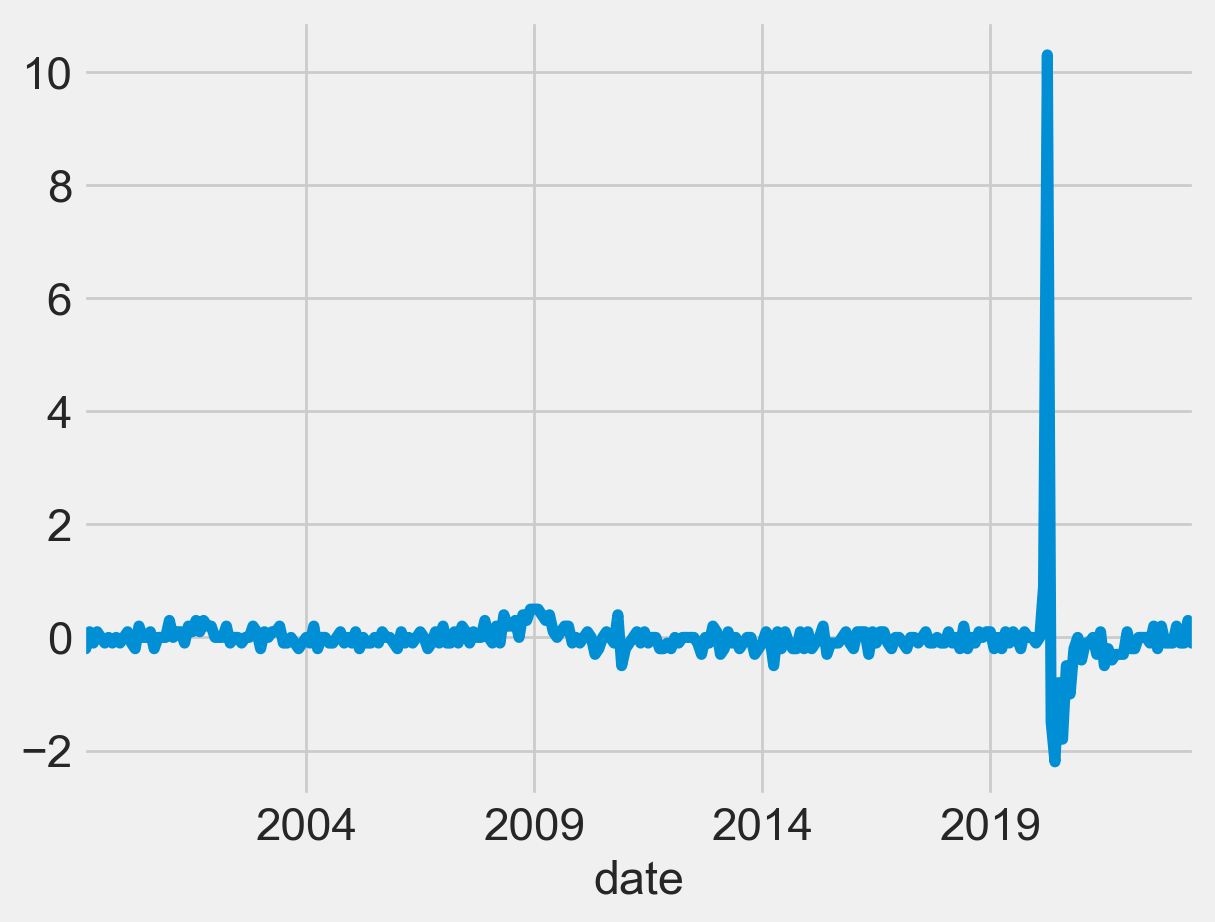

In [21]:
udiff.plot()

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

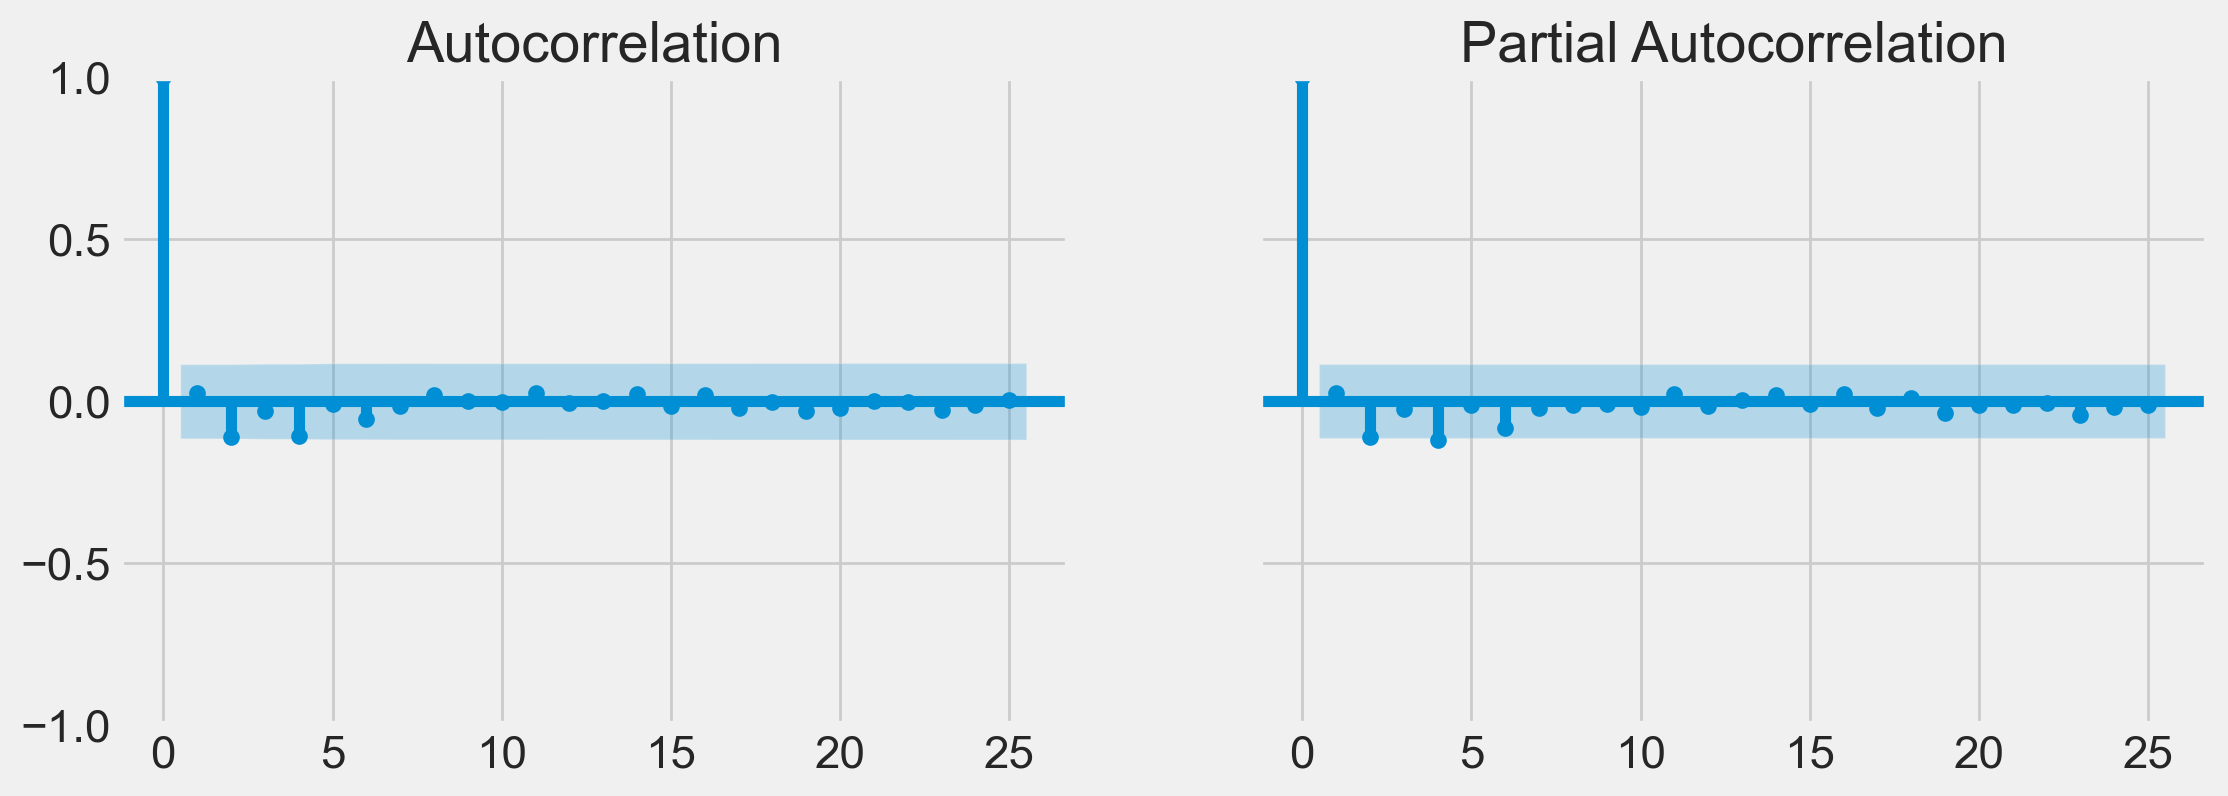

In [22]:
# Plot the ACF and PACF
autocorr_plots(udiff)

The differenced values appear to be stationary, with no significant correlation between each time step and the next. Let's check by performing the ADF test on the differenced series:

In [23]:
adf_test = adfuller(udiff)
print(f'p-value: {adf_test[1]}')

p-value: 8.112040063346367e-18


The p-value is very low, so we reject the null hypothesis that there is a unit root, and we can use the assumption that the differenced series is stationary.

So let's go ahead and use `d=1`.

## How to choose the right `p` and `q` parameters
---
<a id="how-to-choose-the-right-p-and-q-parameters"></a>

In general it is never a bad idea to choose your parameters based on hold-out testing. That is to say, checking the performance of your model on future time points based on different choices of `p` and `q` for an ARIMA model.

However, you can get a sense for what parameters will work best based on the autocorrelation and partial autocorrelation plots.

[This site](https://people.duke.edu/~rnau/411arim3.htm) has a very detailed overview of how to use the acf and pacf to determine your parameters.

Below are some basic guidelines which are applicable once your time series is stationary, i.e. you might have to carry out transformations and/or differencing steps before.

After having obtained the stationary time series, inspect the autocorrelation and partial autocorrelation plots.

- Check the autocorrelations.
- If all autocorrelations with a lag larger than q vanish, choose MA(q).
- If there are autocorrelations at all lags (even if maybe very small), check for the partial autocorrelations.
- If the partial autocorrelations for lags larger than p vanish, choose AR(p).
- If both the ACF and PACF show a gradual decay, an ARMA model is likely appropriate as opposed to the AR or MA alone.

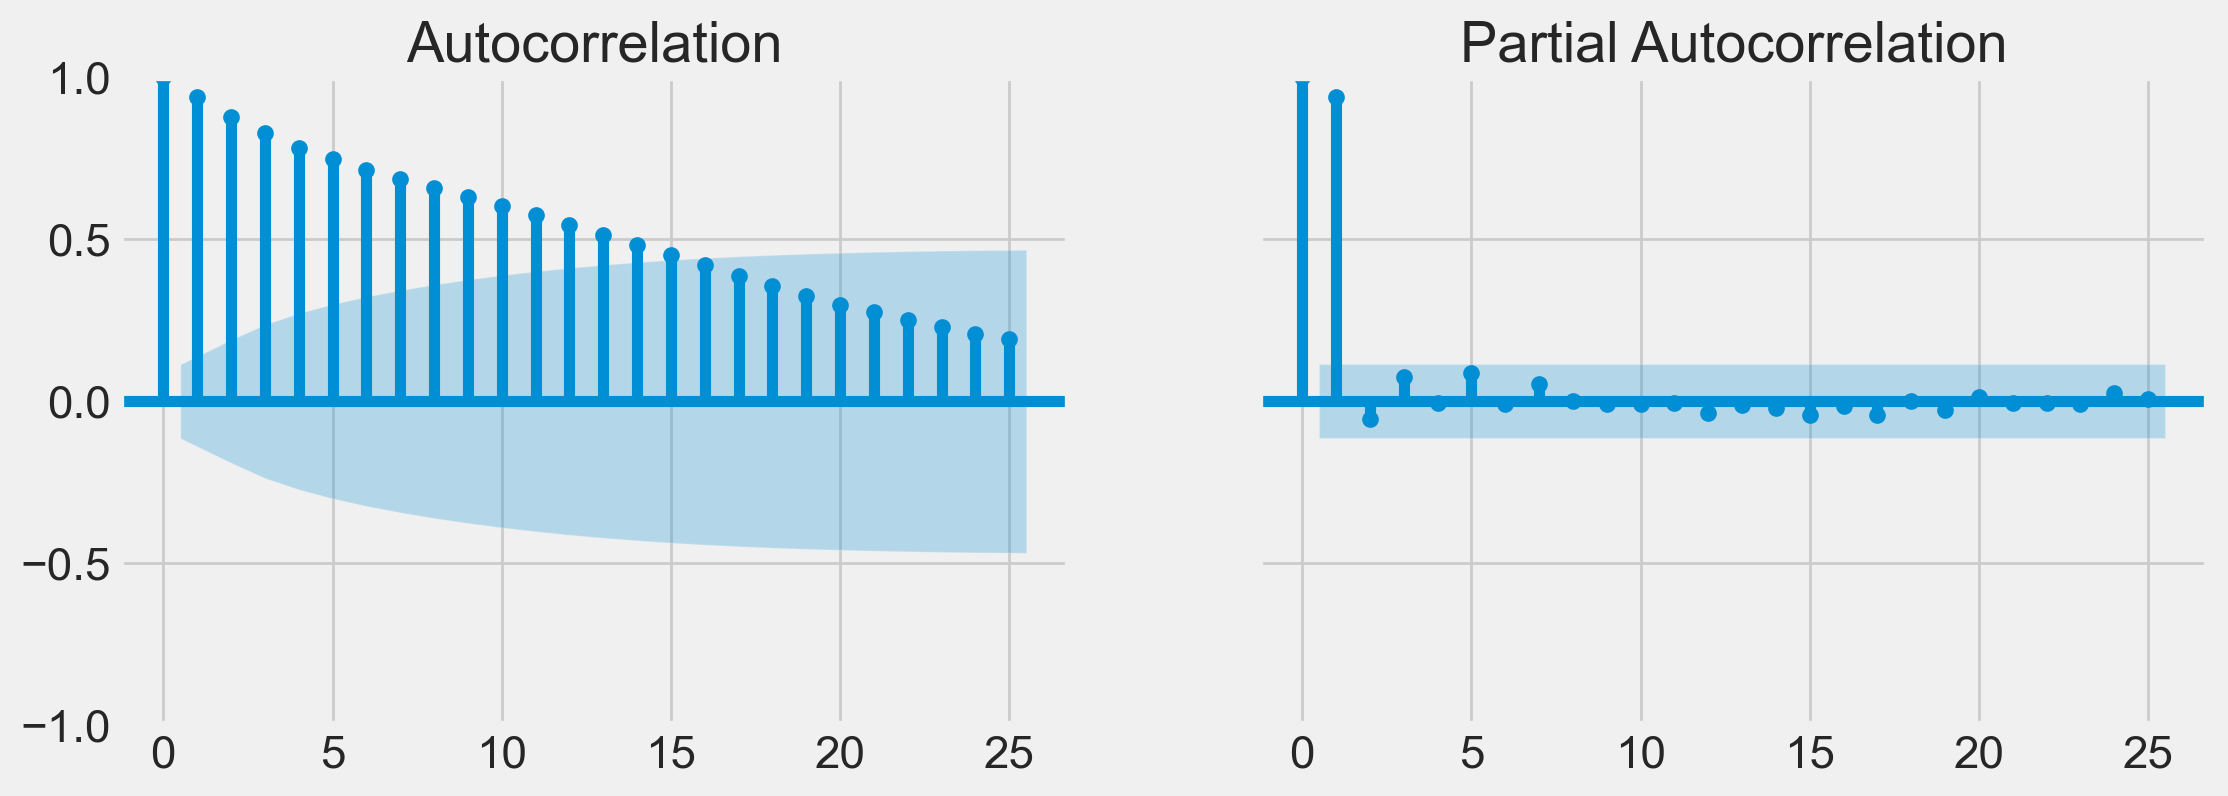

In [24]:
fig, ax = autocorr_plots(urate)

Looking at the plot above we see that there are no significant lags in the PACF after p=1. So we can use `p=1`.

The ACF plot shows autocorrelation for up to lag 15, showing that the values up to 15 lags could be relevant to the current time value. Let's try `q=15`. 

In [25]:
model_1_1_15=ARIMA(X_train, order=(1,1,15)).fit()
print(model_1_1_15.summary())
print(model_1_1_15.model.order)

                               SARIMAX Results                                
Dep. Variable:      unemployment_rate   No. Observations:                  283
Model:                ARIMA(1, 1, 15)   Log Likelihood                -281.847
Date:                Fri, 13 Oct 2023   AIC                            597.693
Time:                        18:34:35   BIC                            659.606
Sample:                    01-31-1999   HQIC                           622.521
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1602      5.506      0.029      0.977     -10.632      10.952
ma.L1         -0.1380      5.505     -0.025      0.980     -10.928      10.652
ma.L2         -0.1401      0.136     -1.032      0.3

<Axes: xlabel='date'>

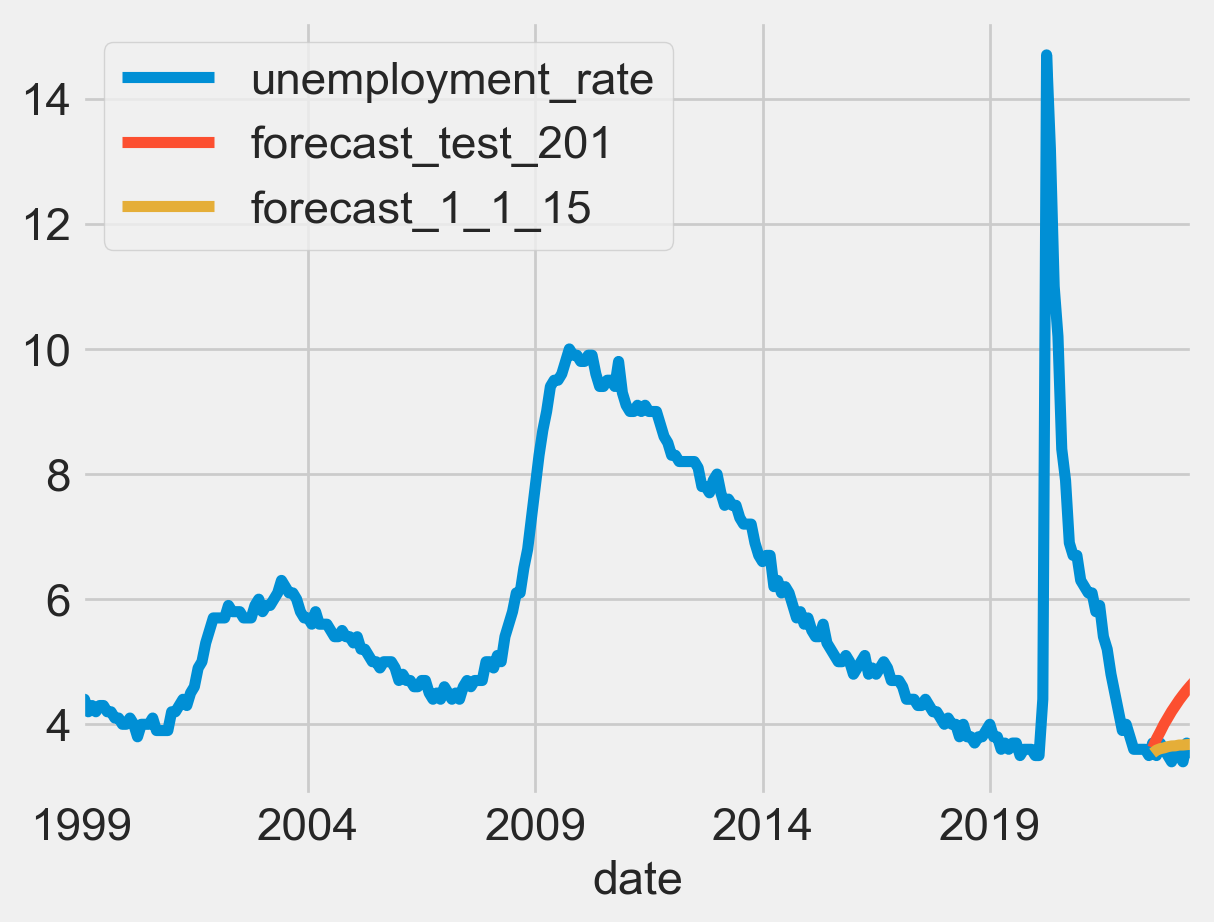

In [26]:
forecast_1_1_15 = model_1_1_15.forecast(len(X_test))

data['forecast_1_1_15'] = [None]*len(X_train) + list(forecast_1_1_15)

data.plot()

<Axes: xlabel='date'>

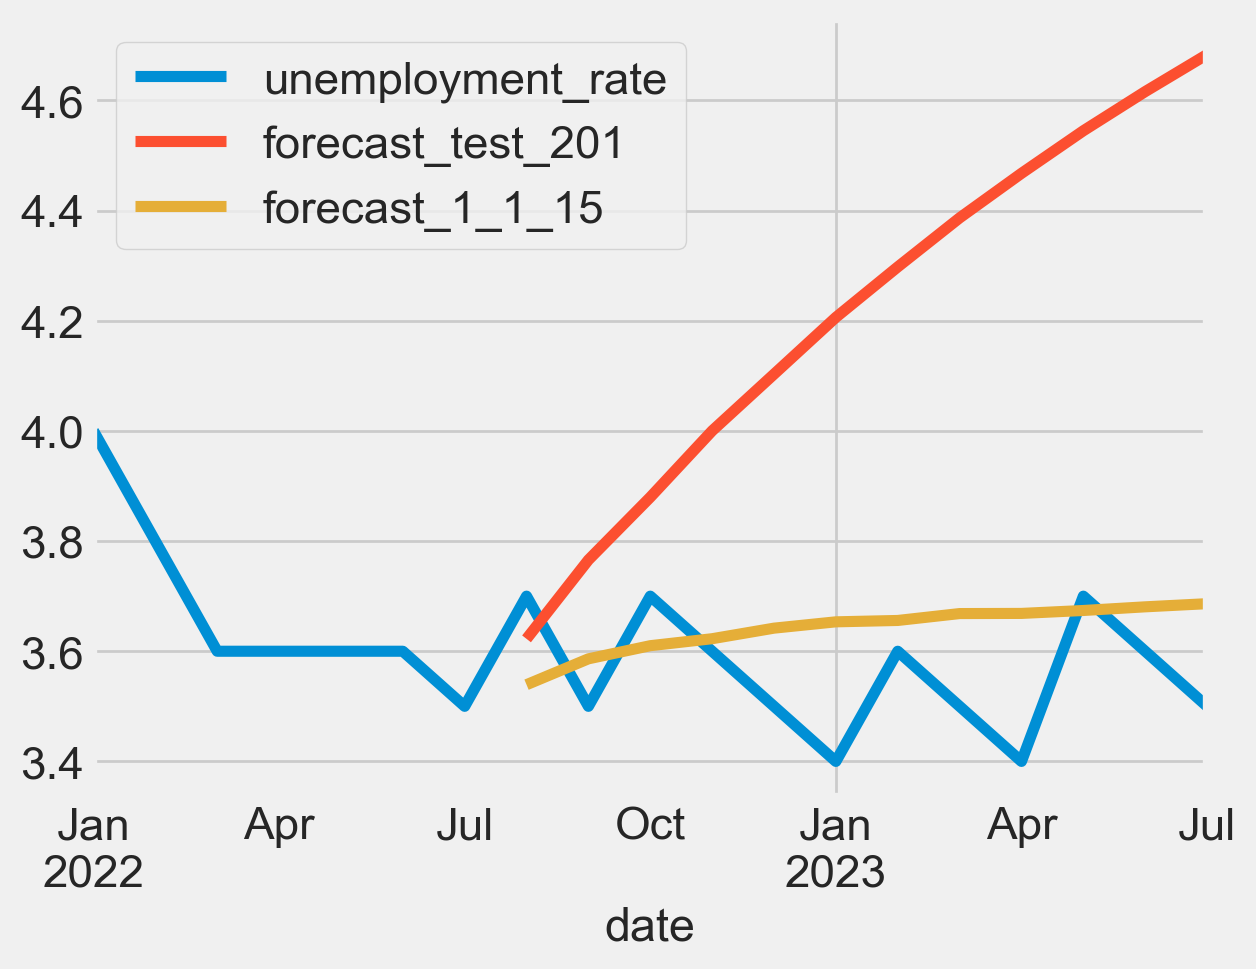

In [27]:
data.loc['2022-01':].plot()

### Residuals

As in linear regression, we can judge the quality of our model by looking at our residuals. We would like that

- there are no trends in the size of the residuals
 - plot the values of the residuals 
- the residuals are uncorrelated
 - plot the autocorrelations of the residuals (correlogram)
- the residuals are normally distributed 
 - compare to the standard normal distribution through quantile-quantile plot and histogram

In [28]:
from scipy import stats
import statsmodels.api as sm

def residual_plot(res):
    resid_standard = (res - res.mean()) / res.std()

    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')
    plt.tight_layout()
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14988\1919325729.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res, ax=ax[1, 1], label='kde estimate')


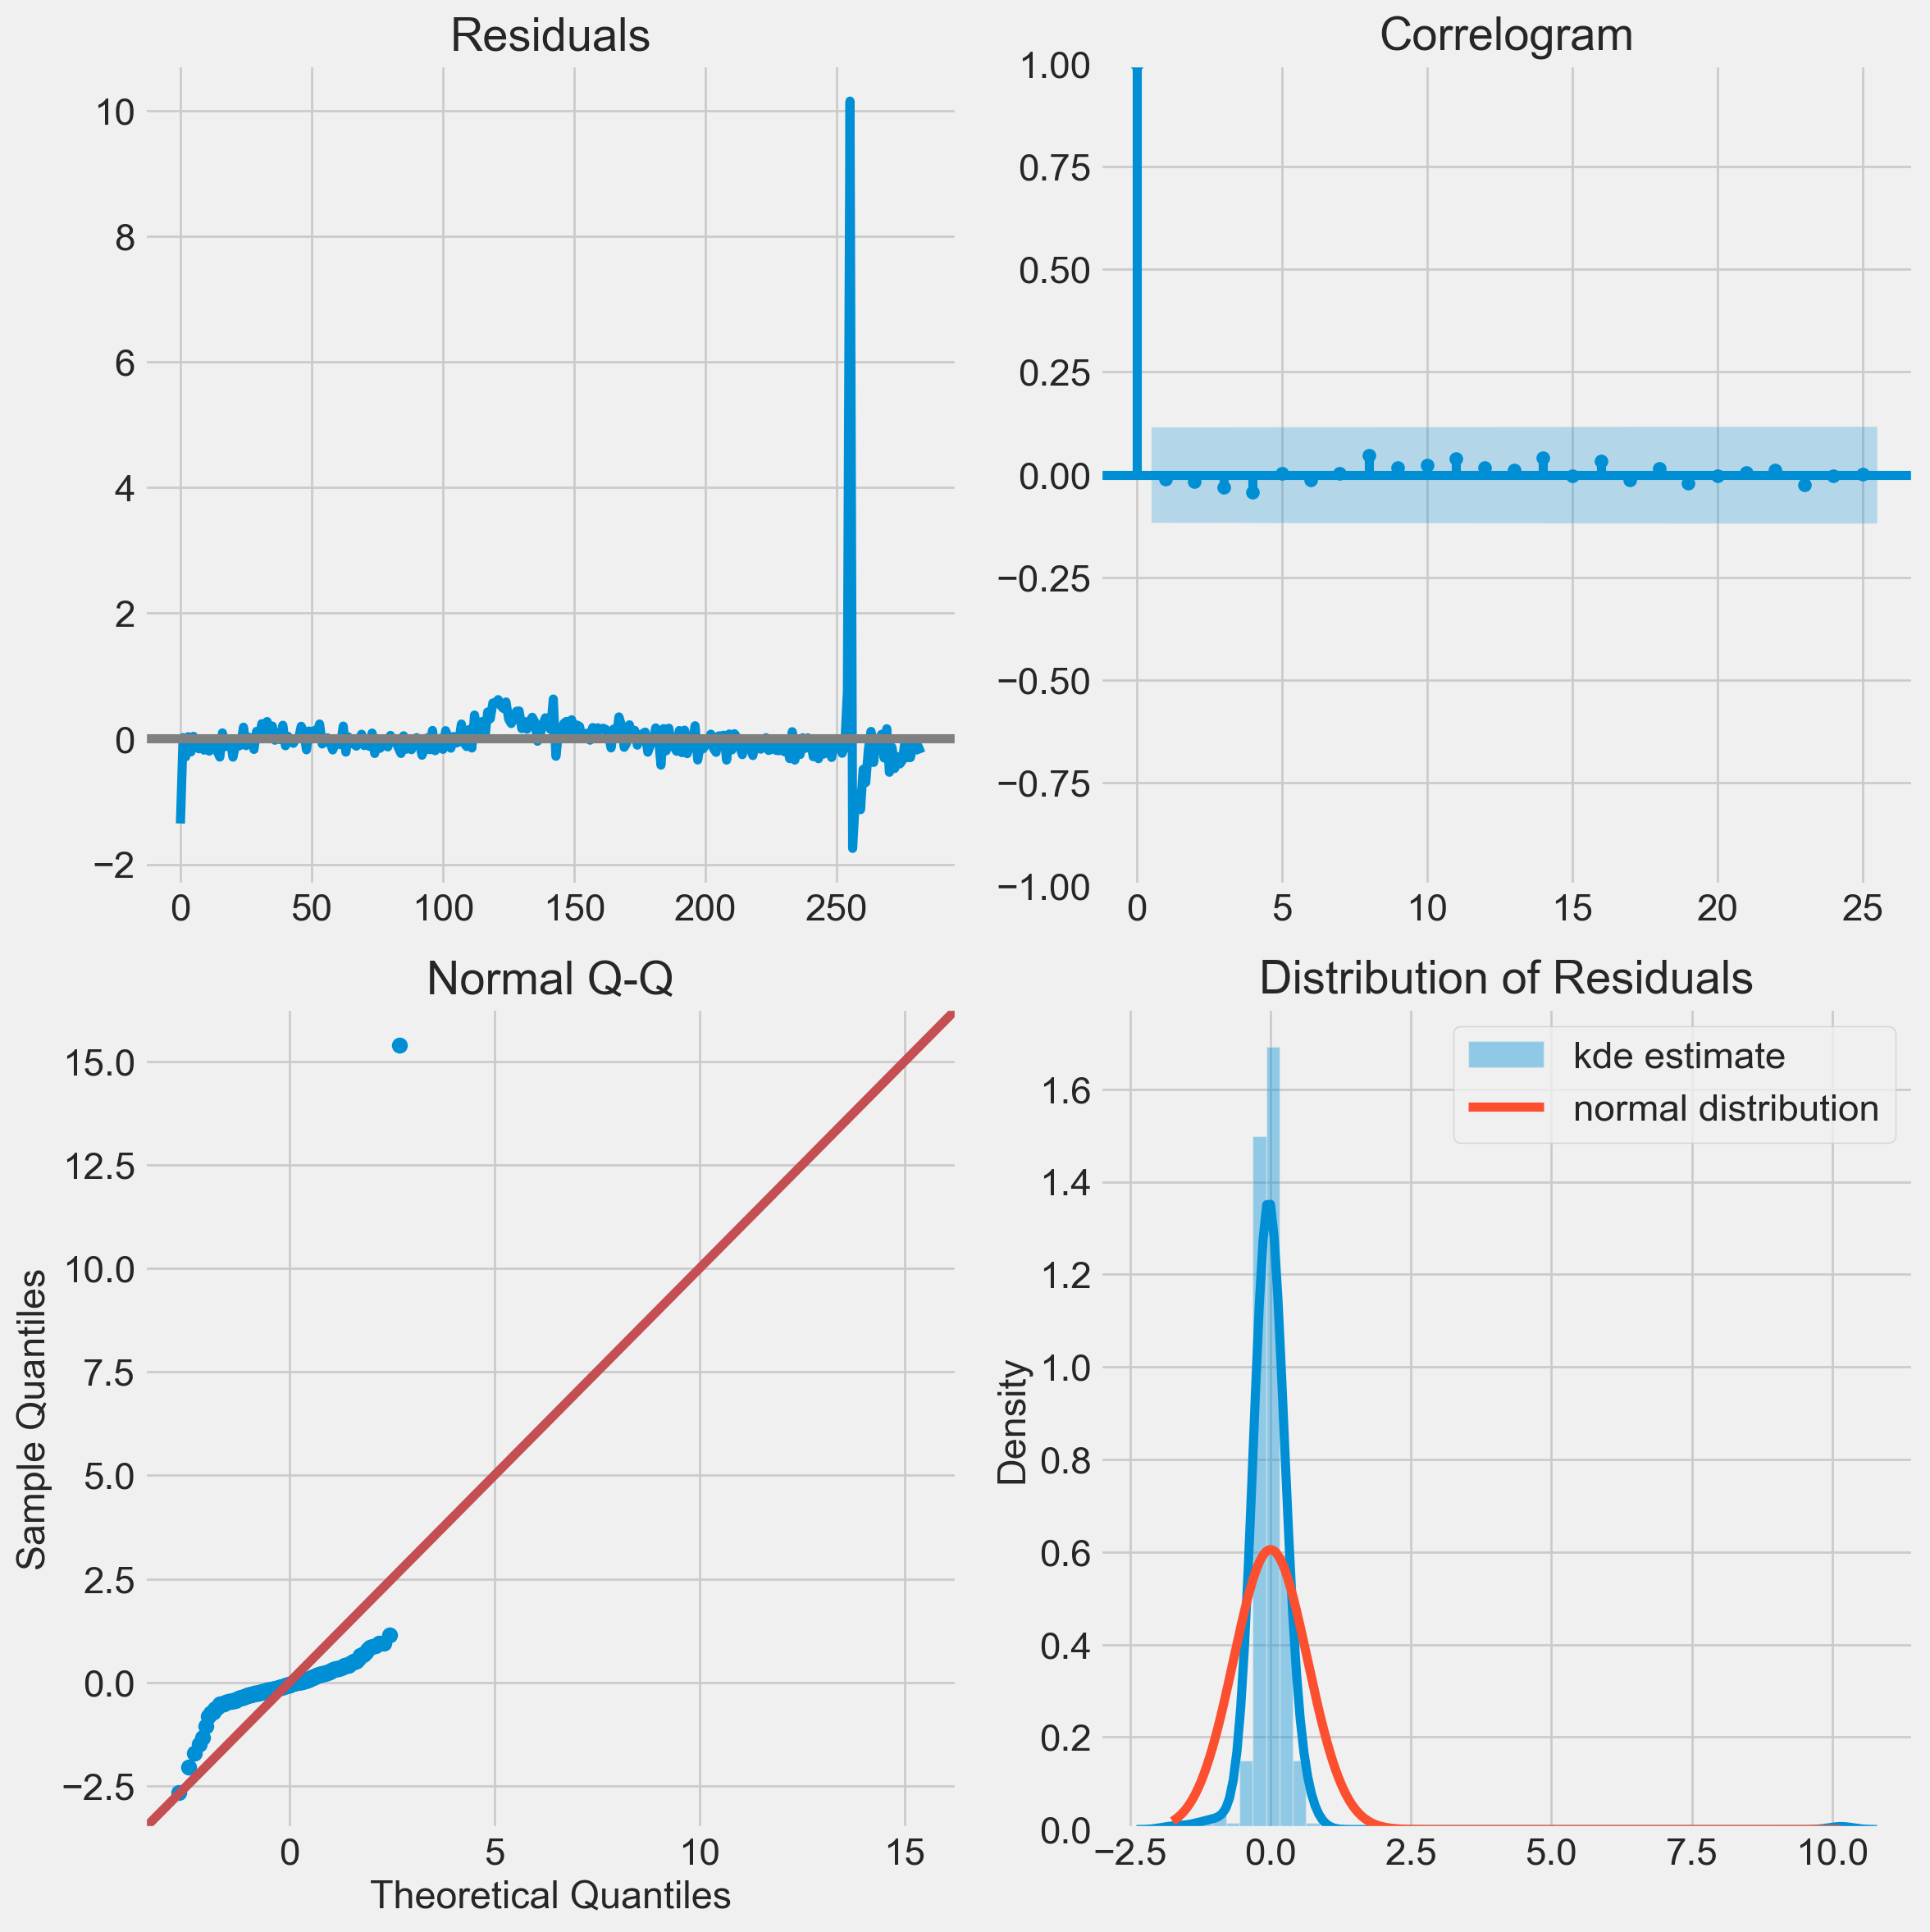

In [29]:
residual_plot(model_test_201.resid.values)

### Automatic selection of ARIMA model

We can use automatic methods to select the parameters for the ARIMA model. One package that is available is `pmdarima`, you can install if it's the first time you are using it:

In [31]:
pip install pmdarima


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/566.2 kB ? eta -:--:--
     ------ -------------------------------- 92.2/566.2 kB 1.7 MB/s eta 0:00:01
     -------- ----------------------------- 122.9/566.2 kB 1.8 MB/s eta 0:00:01
     ----------- -------------------------- 174.1/566.2 kB 1.3 MB/s eta 0:00:01
     --------------- ---------------------- 225.3/566.2 kB 1.1 MB/s eta 0:00:01
     --------------- ---------------------- 235.5/566.2 kB 1.0 MB/s eta 0:00:01
     --------------------- ---------------- 317.4/566.2 kB 1.1 MB/s eta 0:00:01
     ------------------------- ------------ 378.9/566.2 kB 1.1 MB/s eta 0:00:01
     -------------------------------- ----- 481.3/566.2 kB 1.3 MB/s eta 0:00:01
     ---------------------------------- --- 512.0/566.2 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 566.2/566.2 kB 1.2 MB/s eta 0:00:00
  Obtaining dependency information for Cython!=0.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [32]:
import pmdarima as pm
auto_arima = pm.auto_arima(X_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

<Axes: xlabel='date'>

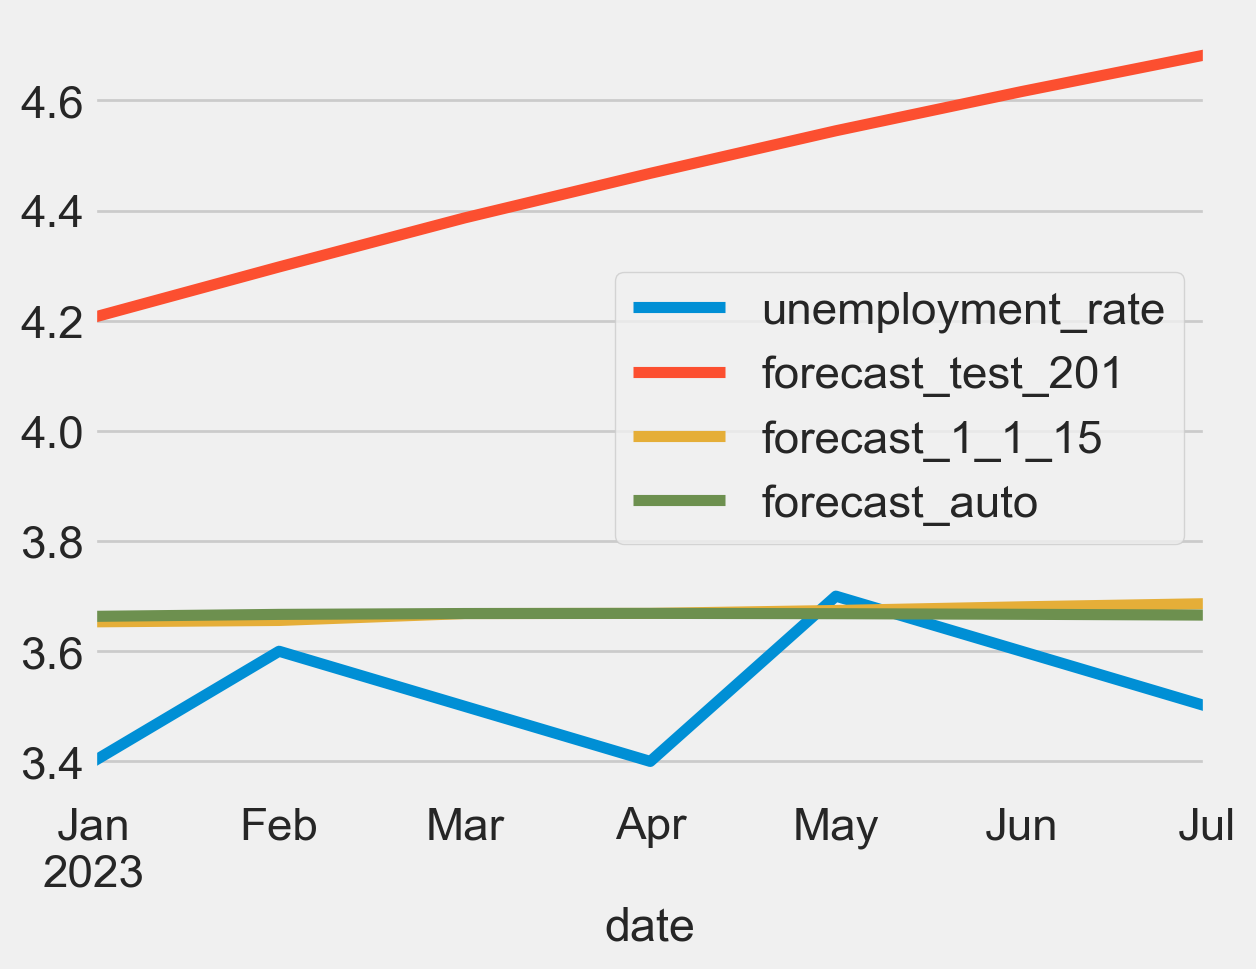

In [33]:
forecast_test_auto = auto_arima.predict(n_periods=len(X_test))
data['forecast_auto'] = [None]*len(X_train) + list(forecast_test_auto)

data.loc['2023-01':].plot()

As you can see the forecast for the automatic ARIMA are similar with order = (1,1,2) to the one that we used with order=(1,1,15). A simpler model is always preferred.
    

### Forecast for this model

We distinguish different ways of forecasting.

- In-sample forecasts:
 - We predict one-step ahead using the true values up to that point (non-dynamic forecasting).
 - We use the first few values in the time series to predict the next ones, and the ones further in the future using the predicted values as input (dynamic forecasting).
- Out-of-sample forecasts:
 - We predict further into the future using predicted values as input.
 - If we predict for a long time into the future, our forecast will be (very close to) the mean.
 - It is important to indicate confidence intervals for our forecast. We can never be sure about the future, but we can be reasonably sure that future values will stay within certain bounds.
 - The width of the confidence interval becomes constant. This is due to stationarity. For a non-stationary time series, the confidence interval would become wider and wider.

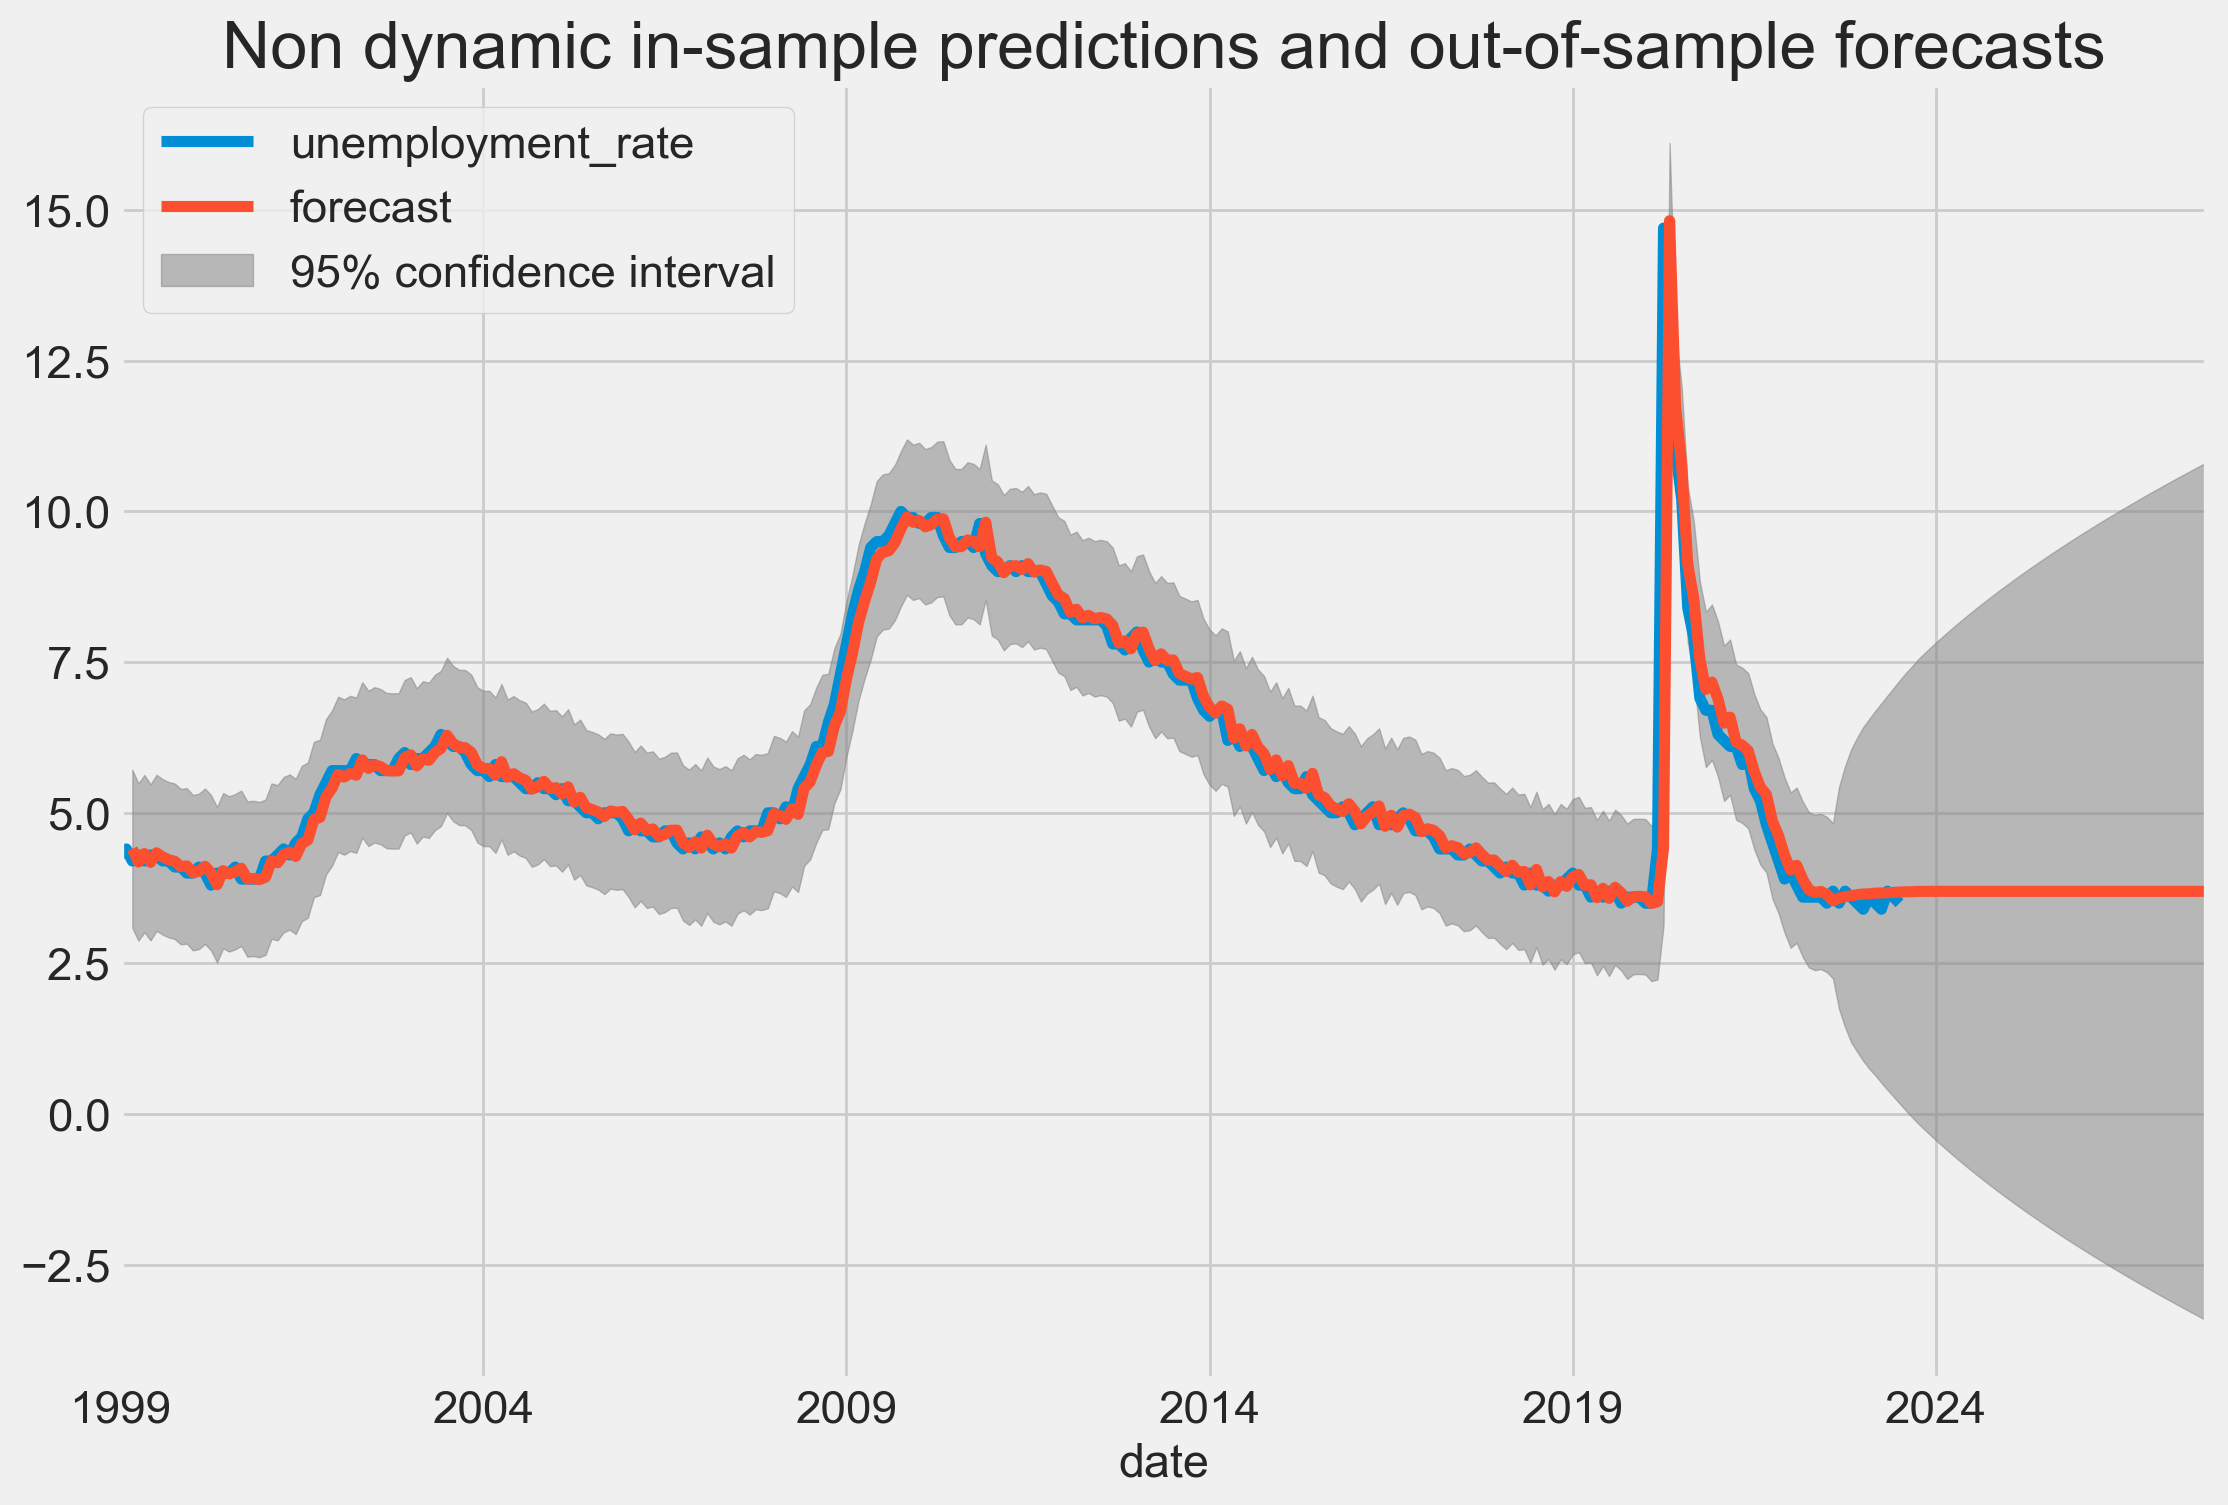

In [34]:
from statsmodels.graphics.tsaplots import plot_predict

# Start predicting from which time period
init_1 = 2

# Stop predicting 50 time units into the future (50 months)
end_1 = len(urate)+50
fig, ax = plt.subplots(figsize=(12,8))
urate.plot()
plot_predict(model_1_1_15,init_1,end_1,dynamic=False,plot_insample=True,ax=ax)
ax.set_title('Non dynamic in-sample predictions and out-of-sample forecasts',fontsize=24)
plt.show()

Setting `dynamic=True` uses each predicted value to predict the next, instead of using the true values, so there will be a difference depending on where the prediction starts

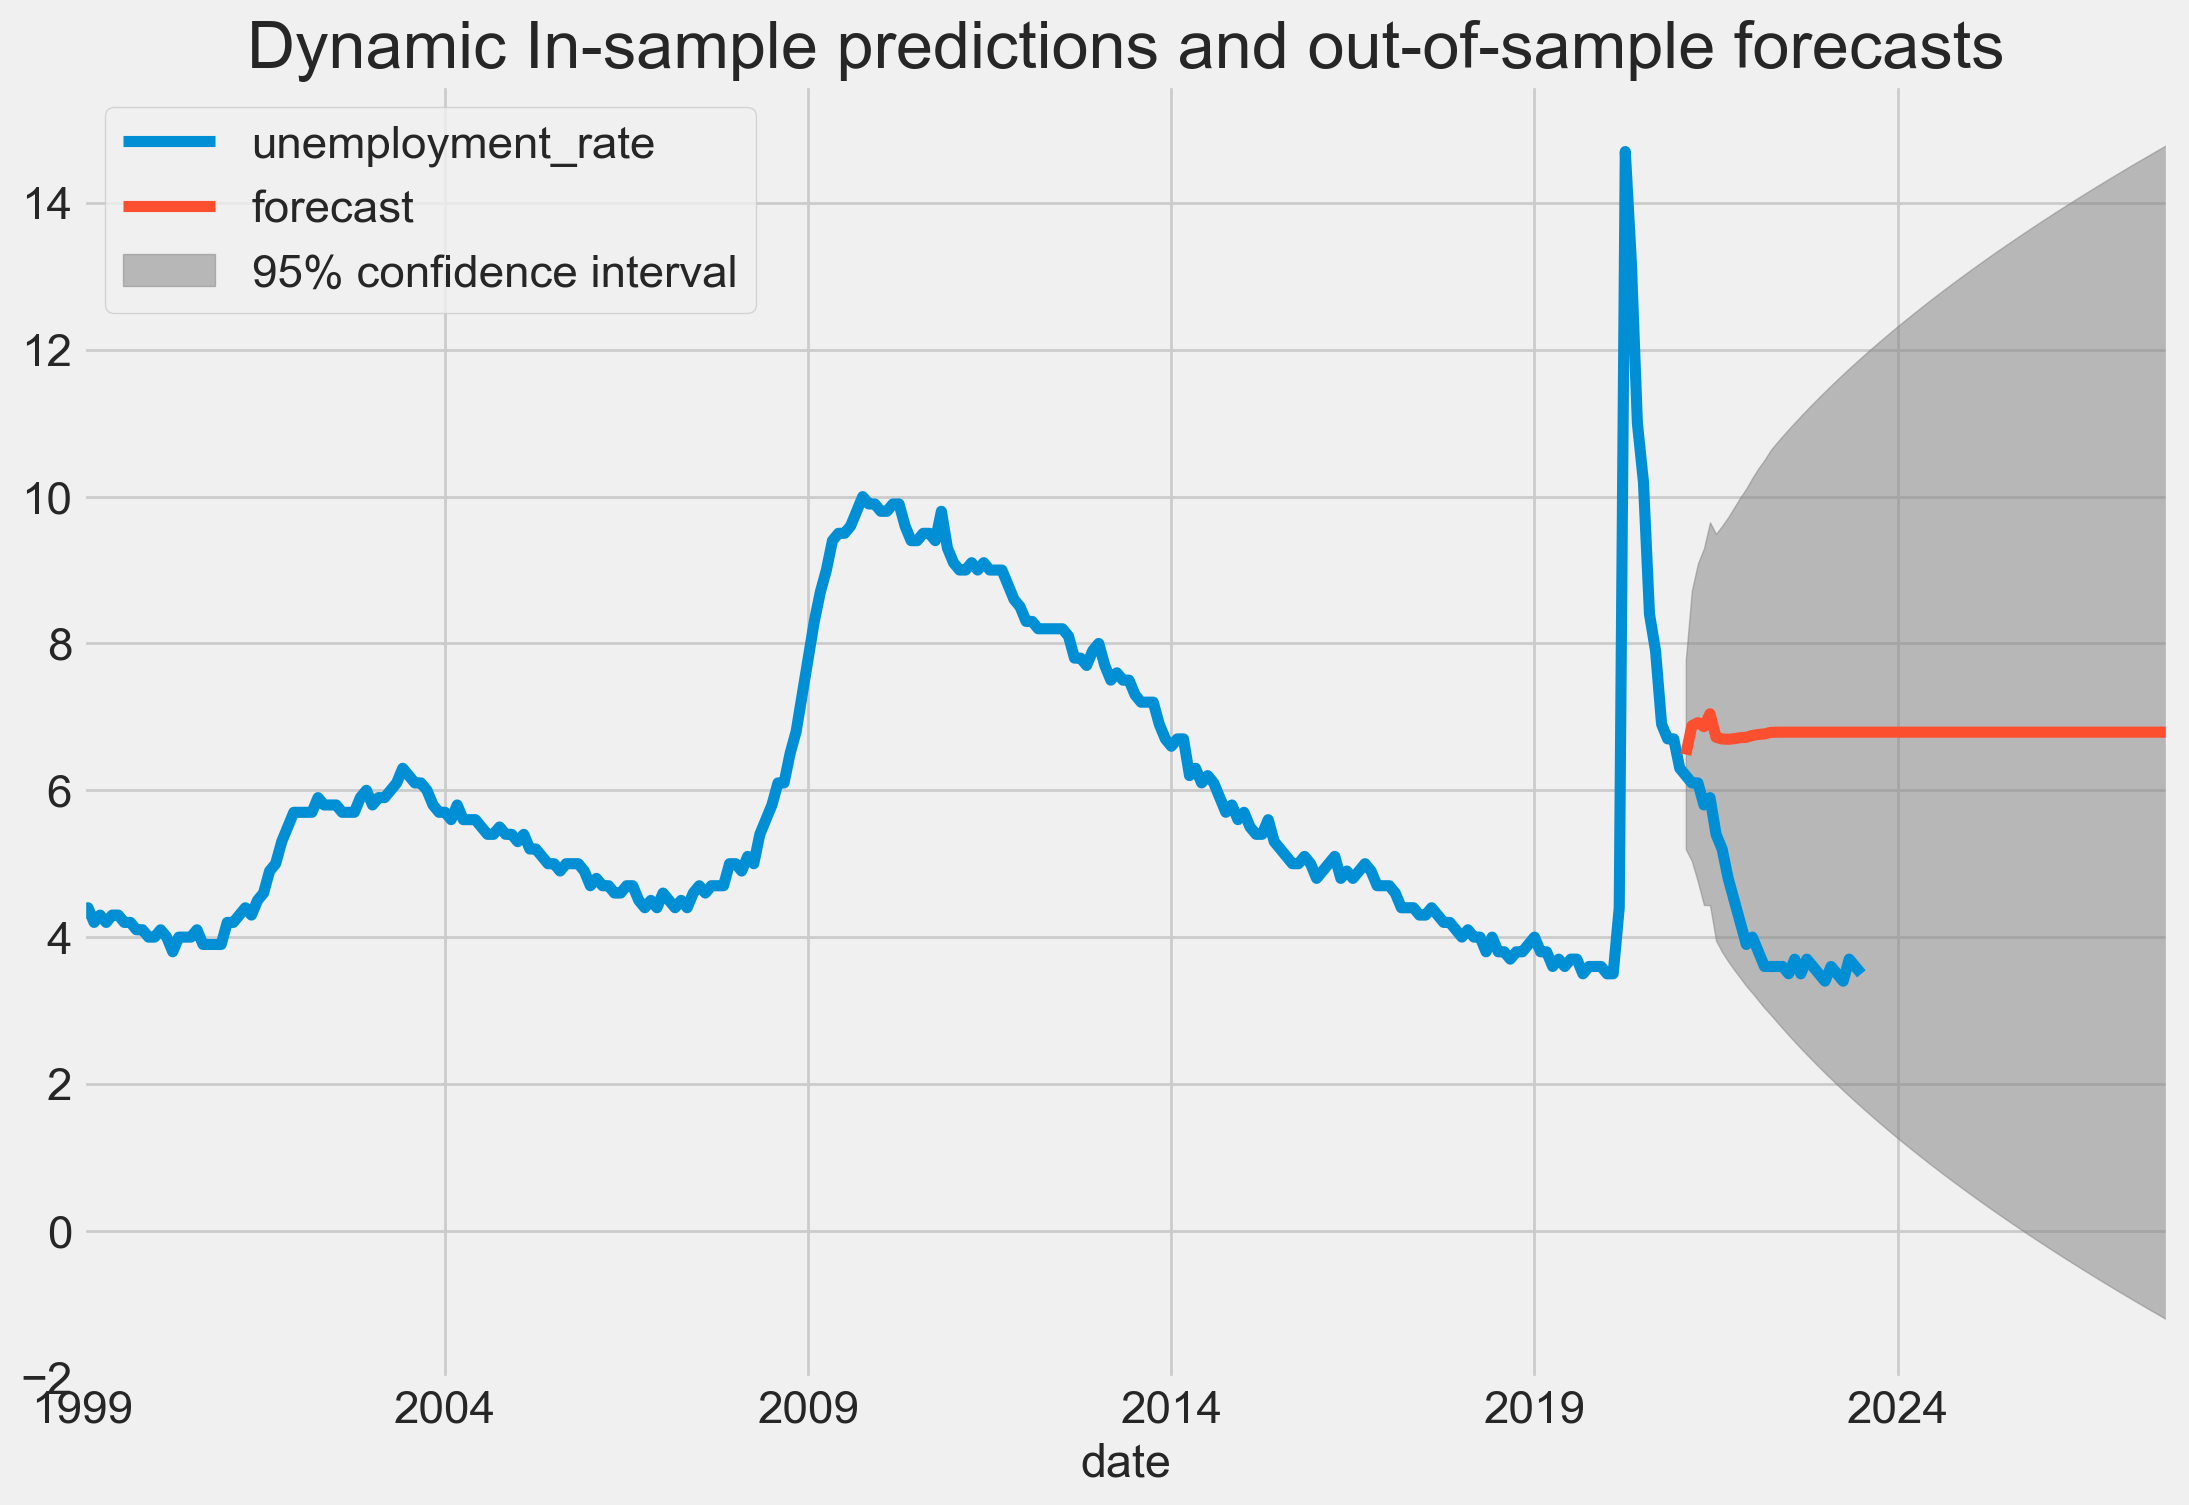

In [38]:
from statsmodels.graphics.tsaplots import plot_predict

# Start predicting from which time period
#init_1 = 2
init_1=len(urate)-30
# Stop predicting 50 time units into the future (50 months)
end_1 = len(urate)+50
fig, ax = plt.subplots(figsize=(12,8))
urate.plot()
plot_predict(model_1_1_15,init_1,end_1,dynamic=True,plot_insample=True,ax=ax)
ax.set_title('Dynamic In-sample predictions and out-of-sample forecasts',fontsize=24)
plt.show()

### Scores

We can use our usual scores to compare true and predicted values.

In [39]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(X_test, forecast_test_auto)
mape = mean_absolute_percentage_error(X_test, forecast_test_auto)
mse = mean_squared_error(X_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(X_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.12979202329720443
mape - auto: 0.037001299375280815
rmse - auto: 0.15067503674153918


In [40]:
mae = mean_absolute_error(X_test, forecast_1_1_15 )
mape = mean_absolute_percentage_error(X_test,forecast_1_1_15 )
mse = mean_squared_error(X_test, forecast_1_1_15)
rmse = np.sqrt(mean_squared_error(X_test, forecast_1_1_15 ))


print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'mse - manual: {mse}')
print(f'rmse - manual: {rmse}')


mae - manual: 0.12840328536063336
mape - manual: 0.03659087842841121
mse - manual: 0.02264771155100656
rmse - manual: 0.15049156637834082


In [41]:
mae = mean_absolute_error(X_test, forecast_test_201 )
mape = mean_absolute_percentage_error(X_test,forecast_test_201 )
mse = mean_squared_error(X_test, forecast_test_201)
rmse = np.sqrt(mean_squared_error(X_test, forecast_test_201 ))


print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'mse - manual: {mse}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.6689603468849512
mape - manual: 0.189627540328867
mse - manual: 0.5700201294785183
rmse - manual: 0.7549967744821949


## Summary of time series modeling

- Visualize the time series
- Make the time series stationary
 - Is there a clear trend in the data?
 - Are there periodic patterns / seasonal effects?
- Plot ACF/PACF to seek optimal parameters
- Build the ARIMA model
- Predict the future
    - Obtain in-sample and out-of-sample forecasts
    - Evaluate model scores

## Model Limitations

- We made assumptions about stationarity
- Trends can be removed by transformation and/or differencing
- Long term patterns in the correlations can be taken into account by Seasonal ARIMA models 
- Time dependent variances of the error term can be taken into account by GARCH models
- There are many more specialized models

## Additional Resources

- [Blackarbs - Time series analysis in python - linear models to garch](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)
- [Quantstart - time series analysis](https://www.quantstart.com/articles#time-series-analysis)
- [Digital Ocean - A guide to time series forecasting](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
- [Harvard lectures](http://iacs-courses.seas.harvard.edu/courses/am207/blog/lecture-17.html)
- [Statsmodels ARMA Example](http://www.statsmodels.org/devel/examples/notebooks/generated/tsa_arma_0.html)